# Ensambles - Bagging

A lo largo del notebook vamos a trabajar con el siguiente dataset:

https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

El objetivo de este analisis será predecir si lloverá o no al día siguiente.

## 1. EDA y Preprocesamiento

In [24]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier

import sklearn.metrics as metrics
from sklearn.model_selection import learning_curve



1. Abrir el dataset

In [46]:
data = pd.read_csv("DS_Bitácora_27_Weather.csv")
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


Contamos cuántos valores no-nulos hay

In [40]:
data.count().sort_values()

Sunshine          74377
Evaporation       81350
Cloud3pm          85099
Cloud9am          88536
Pressure9am      128179
Pressure3pm      128212
WindDir9am       132180
WindGustDir      132863
WindGustSpeed    132923
WindDir3pm       138415
Humidity3pm      138583
Temp3pm          139467
WindSpeed3pm     139563
Humidity9am      140419
RainToday        140787
Rainfall         140787
WindSpeed9am     140845
Temp9am          141289
MinTemp          141556
MaxTemp          141871
Date             142193
Location         142193
RISK_MM          142193
RainTomorrow     142193
dtype: int64

2. Tirar las columnas que no nos interesan, entre ellas las que tienen pocos datos (menos de cien mil). Además, tirar 'Location' y 'Date', ya que no nos interesa el lugar ni fecha (al menos en este análisis), y 'RISK_MM', porque es un *leak*. **Para googlear**: ¿qué es un leak?

In [47]:
columnas_descartables = ['Location','Date','RISK_MM','Sunshine']
data = data.drop(columns=columnas_descartables)
data.shape

(142193, 20)

3. Tirar todas las filas que tengan valores nulos.

In [48]:
data = data.dropna()
print(data.shape)
data.head()

(61981, 20)


,MinTemp,MaxTemp,Rainfall,Evaporation,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
5939,17.9,35.2,0.0,12.0,SSW,48.0,ENE,SW,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No
5940,18.4,28.9,0.0,14.8,S,37.0,SSE,SSE,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No
5942,19.4,37.6,0.0,10.8,NNE,46.0,NNE,NNW,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No
5943,21.9,38.4,0.0,11.4,WNW,31.0,WNW,WSW,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No
5944,24.2,41.0,0.0,11.2,WNW,35.0,NW,WNW,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No


4. Para simplificar el preprocesamiento, también tirar todas las columnas que tengan valores categóricos. ¿Por qué no nos molesta tirar 'RainToday'?

In [49]:
columnas_descartables = ['RainToday','WindGustDir','WindDir9am','WindDir3pm']
data = data.drop(columns=columnas_descartables)
data.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
5939,17.9,35.2,0.0,12.0,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No
5940,18.4,28.9,0.0,14.8,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No
5942,19.4,37.6,0.0,10.8,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No
5943,21.9,38.4,0.0,11.4,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No
5944,24.2,41.0,0.0,11.2,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No


5. Realizar un countplot para ver cuántos casos hay de lluvia y no-lluvia.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


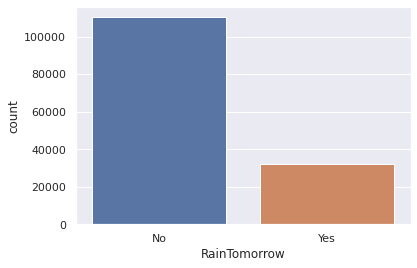

In [43]:
sns.countplot(data.RainTomorrow)
plt.show()

Y hacer el `pairplot` para ver cómo se relacionan las variables. Recuerden que este gráfico puede llevar bastante tiempo. También recuerden que pueden agrandar el gráfico haciendo doble click en él.

In [31]:
sns.pairplot(data.sample(frac = 0.1), hue = 'RainTomorrow')

Error in callback <function flush_figures at 0x7fc5d96aa3b0> (for post_execute):


KeyboardInterrupt: ignored

Hay algunas que parecen *correlacionadas*. Tratamos de cuantificarlo.

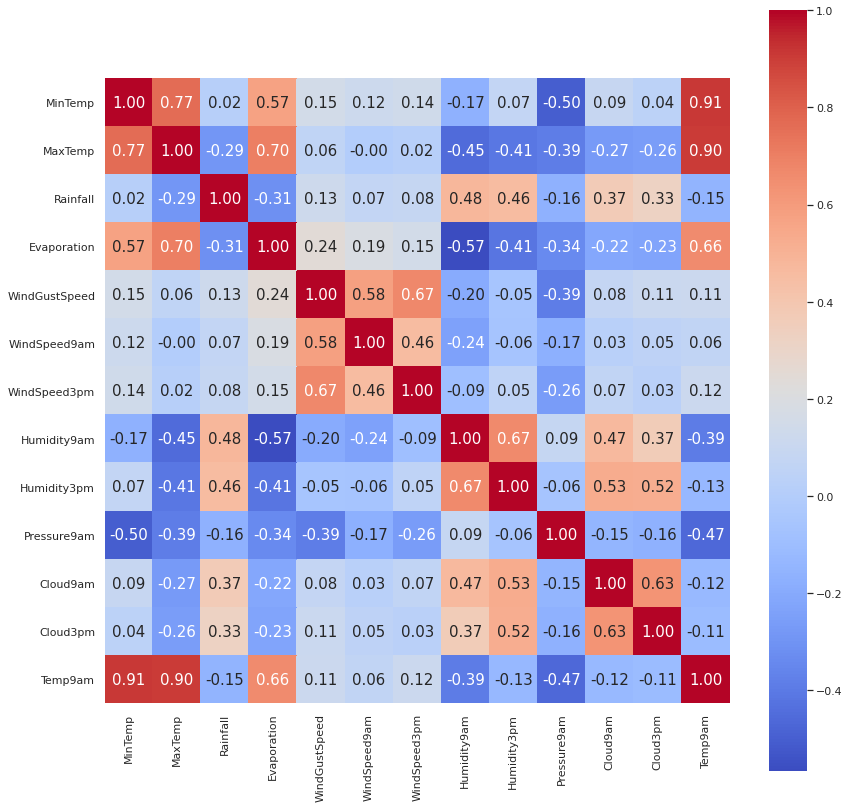

In [36]:
corr = data.drop(columns = ['RainTomorrow']).corr(method='spearman') # .corr is used for find corelation
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= data.drop(columns = ['RainTomorrow']).columns, 
           yticklabels= data.drop(columns = ['RainTomorrow']).columns,
           cmap= 'coolwarm')

plt.show()

En base a la correlación, podemos descartar (o no) algunas variables. **Para pensar**, ¿por qué haríamos (o no) esto?

In [50]:
data = data.drop(columns=['Temp3pm', 'Pressure3pm'])

6. Llevar `RainTomorrow` a una variable númerica

In [51]:
data['RainTomorrow'] = data['RainTomorrow'].map({'Yes':1,'No':0})
data.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,Temp9am,RainTomorrow
5939,17.9,35.2,0.0,12.0,48.0,6.0,20.0,20.0,13.0,1006.3,2.0,5.0,26.6,0
5940,18.4,28.9,0.0,14.8,37.0,19.0,19.0,30.0,8.0,1012.9,1.0,1.0,20.3,0
5942,19.4,37.6,0.0,10.8,46.0,30.0,15.0,42.0,22.0,1012.3,1.0,6.0,28.7,0
5943,21.9,38.4,0.0,11.4,31.0,6.0,6.0,37.0,22.0,1012.7,1.0,5.0,29.1,0
5944,24.2,41.0,0.0,11.2,35.0,17.0,13.0,19.0,15.0,1010.7,1.0,6.0,33.6,0


### Datos de entrenamiento y casos *benchmark*

Generamos casos base contra los cuales comparar nuestros resultados.

1. Elegir variables de entrenamiento (empezar con dos) y separar las etiquetas

In [52]:
columnas_entrenamiento = ['MaxTemp']
X = data[columnas_entrenamiento]
y = data.RainTomorrow

2. Generar un modelo que diga siempre que NO va a llover y medir su exactitud.

In [54]:
#Todos Ceros
y_pred = np.zeros(y.shape)
accuracy_ceros = metrics.accuracy_score(y,y_pred)
print(accuracy_ceros)

0.7815136896790952


Y generar otro modelo que diga siempre que va a llover y medir su exactitud.

In [55]:
#Todos Unos
y_pred = np.ones(y.shape)
accuracy_unos = metrics.accuracy_score(y,y_pred)
print(accuracy_unos)

0.2184863103209048


**3. - Challenge:**  Entrena un árbol de decisión sobre este dataset. Intenta obtener el mejor desempeño que creas posible, optimizando sus hiperparámetros. 

In [ ]:
# COMPLETAR

## 2. Bagging

Separamos entre train y test

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

Recuerden que el objetivo de bagging es entrenar distintos modelos, donde cada uno vea distintas porciones del set de entrenamiento. Entonces, vamos a entrenar distintos árboles de decisión y mostrarles distintas porciones del set de datos. Lo vamos a hacer en un `for`.

1. Crear una lista vacía donde guardaremos los modelos entrenados y elegir cuántos modelos entrenar (Empezar por algún valor entre 5 y 10).

In [57]:
lista_de_modelos = []
N_modelos = 10

2. Entrenar cada modelo y guardar cada modelo entrenado en una lista. Para hacer el split, usar la función `train_test_split`. ¿Sobre qué conjunto van a hacer el split?¿Hay que fijar el `random_state`? 

In [59]:
for i in range(N_modelos):
    X_train_boostrap, _, y_train_boostrap, _ = train_test_split(X_train, y_train, test_size=0.5, stratify = y_train)
    clf = DecisionTreeClassifier(max_depth = None) #Notar que lo dejamos overfitear
    clf.fit(X_train_boostrap, y_train_boostrap)
    lista_de_modelos.append(clf)

3. Evaluar el accuracy de cada modelo usando el conjunto de held_out

In [60]:
for idx, modelo in enumerate(lista_de_modelos):
    y_test_pred = modelo.predict(X_test)
    print('Accuracy Modelo ', idx, ' es ', metrics.accuracy_score(y_test, y_test_pred))

Accuracy Modelo  0  es  0.7799946222102716
Accuracy Modelo  1  es  0.780586179080398
Accuracy Modelo  2  es  0.7812315138478085
Accuracy Modelo  3  es  0.7813928475396612
Accuracy Modelo  4  es  0.781339069642377
Accuracy Modelo  5  es  0.7819306265125033
Accuracy Modelo  6  es  0.7806937348749664
Accuracy Modelo  7  es  0.7802097337994084
Accuracy Modelo  8  es  0.7812852917450928
Accuracy Modelo  9  es  0.7804786232858295


Parecen estar un poco overfitteados, que era lo que esperábamos.

4. Evaluar el accuracy de todo el ensamble usando el conjunto de held_out. Vamos a hacerlo usando un promedio de las probabilidades que devuelven cada árbol. Si la probabilidad promedio es mayor a 0.5, clasificamos como positivo. Para ello:
    1. Inicializar un arreglo de probabilidades del tamaño de la cantidad de instancias del conjunto de test en ceros.

In [61]:
probs_test_pred = np.zeros(X_test.size)

B. Recorrer la lista de modelos y predecir las probabilidades. Mirar como es el `shape` de ese arreglo predicho. Elegir las probabilidades que correspondan a la clase positiva. Luego, sumarlas al vector que definieron antes.

In [63]:
for modelo in lista_de_modelos:
    probs_test_pred_modelo = modelo.predict_proba(X_test)
    print(probs_test_pred_modelo.shape)
    # Cuando esten seguros de lo que quieran sumar, descomentar la linea de abajo y completar
    probs_test_pred +=probs_test_pred_modelo[:,1]
    

(18595, 2)
(18595, 2)
(18595, 2)
(18595, 2)
(18595, 2)
(18595, 2)
(18595, 2)
(18595, 2)
(18595, 2)
(18595, 2)


C. Dividir `probs_test_pred` por la cantidad de modelos

In [64]:
probs_test_pred = probs_test_pred/N_modelos

D. Crear las clases predichas (0s y 1s) a partir de comparar la probabilidad predicha con la probabilidad umbral (0.5).

In [65]:
y_test_pred = probs_test_pred>0.5
y_test_pred = y_test_pred.astype(int)

Y evaluar la exactitud de todo el ensamble

In [66]:
print('Accuracy Ensambe ', metrics.accuracy_score(y_test, y_test_pred))

Accuracy Ensambe  0.7811239580532401


5. Explorar el `BagginClassfier` de scikit-learn y algunas de sus características. Usarlo para predecir sobre el train y test, y medir su desempeño.

In [67]:
from sklearn.ensemble import BaggingClassifier

In [68]:
clf = BaggingClassifier(base_estimator=None, bootstrap = True, bootstrap_features=True, n_estimators = 100, n_jobs = -1)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))

0.7827640252616052
0.7815004033342297


6. Si usaron dos features, pueden graficar las fronteras de decisión

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


ValueError: ignored

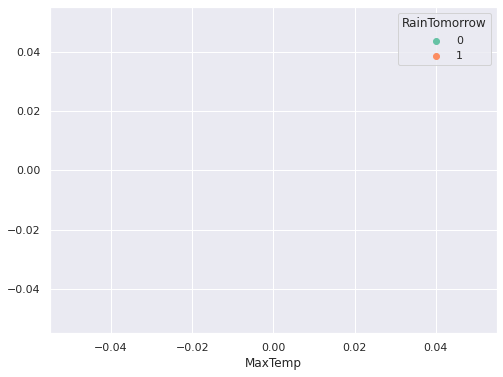

In [70]:
N = 20 #para no graficar todos los puntos y saturar el grafico

plt.figure(figsize = (8,6))

#Grafico Clasificador Sesgado
ax = sns.scatterplot(X_test[::N].MaxTemp, X_test[::N].Humidity3pm, hue=y_test[::N], palette='Set2')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                      np.linspace(*ylim, num=200))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')

plt.show()

## 3. Random Forest

Random Forest, además de aplicar Bagging, también selecciona features al azar, de esa manera descorrelaciona aún más los distintos modelos de árbol creados.

1. Importar de scikit-learn el modelo `RandomForestClassifier`

In [71]:
from sklearn.ensemble import RandomForestClassifier

2. Investigar sus parámetros. En particular, `n_estimators`, `max_features` y `oob_score`. Luego, crear y entrenar un modelo en el conjunto de train.

In [73]:
clf = RandomForestClassifier(n_estimators=100, max_features=1, n_jobs=-1, oob_score = True, random_state = 42)
clf.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

3. Evaluar su desempeño en el conjunto de train y de test.

In [76]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_train,y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))

0.7827640252616052
0.7813928475396612


4. ¿Cuál es su `oob_score_`?¿Y que son `feature_importances_`?

In [77]:
clf.oob_score_

0.780689623380814

In [78]:
clf.feature_importances_

array([1.])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


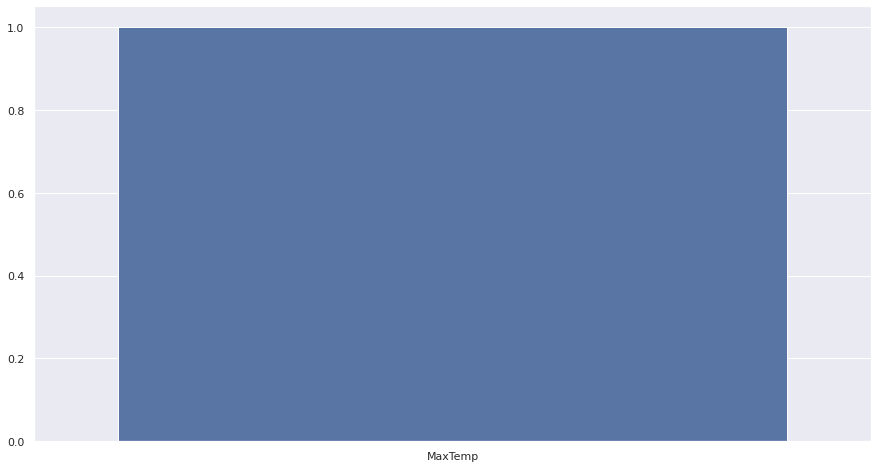

In [79]:
# CORRER ESTA CELDA UNA VEZ QUE HAYAN ESTUDIADO QUE ES OOB_SCORE Y FEATURE_IMPORTANCES

importances = clf.feature_importances_
columns = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize = (15,8))
sns.barplot(columns[indices], importances[indices])
plt.show()

5. ¿Qué hay en la propiedad `estimators_`?

In [80]:
clf.estimators_

[DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=1, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1608637542, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=1, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1273642419, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_featur

6. Elegir uno de los `estimators` y evaluar su desempeño sobre train y test.

In [81]:
clf_tree = clf.estimators_[50]
clf_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 1,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 1224821422,
 'splitter': 'best'}

In [82]:
y_train_pred = clf_tree.predict(X_train)
y_test_pred = clf_tree.predict(X_test)
print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))

0.7823260959756604
0.7809088464641033


¿Está overfiteado?¿Por qué la accuracy sobre el conjunto de train no es 1?

7. Hacer y graficar la curva de validación/complejidad para un modelo Random Forest en función del número de estimadores. No usamos CV porque puede llevar bastante tiempo. Si quieren, lo pueden probar después. Además, obtener su oob_score para graficar en la curva de complejidad (No se preocupen por los mensajes de warning).

In [85]:
train_accuracy = []
test_accuracy = []
oob_scores = []

N_estimadores = [1,2,3,4,5,10,25,50,100,250,500,1000]
for estimadores in N_estimadores:
    print(estimadores)
    clf = RandomForestClassifier(n_estimators=estimadores, n_jobs=-1, oob_score= True, random_state = 42)
    clf.fit(X_train,y_train)
    
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    train_accuracy.append(metrics.accuracy_score(y_train,y_train_pred))
    test_accuracy.append(metrics.accuracy_score(y_test,y_test_pred))
    oob_scores.append( clf.oob_score_)
    
train_accuracy = np.array(train_accuracy)
test_accuracy = np.array(test_accuracy)
oob_scores = np.array(oob_scores)

1
2


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


4


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


5


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


10


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


25
50
100
250
500
1000


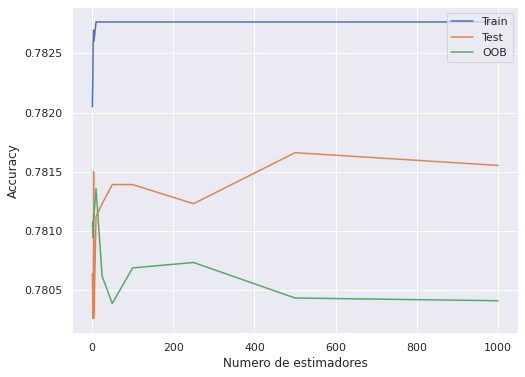

In [86]:
plt.figure(figsize = (8,6))
plt.plot(N_estimadores, train_accuracy, label = 'Train')
plt.plot(N_estimadores, test_accuracy, label = 'Test')
plt.plot(N_estimadores, oob_scores, label = 'OOB')
plt.xlabel('Numero de estimadores')
plt.ylabel('Accuracy')
plt.legend()
# plt.xlim(0,50)
plt.show()

8. Hacer y graficar la curva de aprendizaje para un modelo con 250 estimadores. Puede llevar bastante tiempo, no se preocupen.

In [87]:
clf = RandomForestClassifier(n_estimators=250, n_jobs=-1, oob_score= True, random_state = 42)

train_sizes, train_scores, valid_scores = learning_curve(clf, X_train, y_train, 
                                                         train_sizes = np.linspace(0.0001,1,10),
                                                         scoring = 'accuracy', cv=5)

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(X_train, y_train.mean(axis = 1), color = 'r')
plt.plot(X_test, y_test.mean(axis = 1), color = 'g')

plt.fill_between(COMPLETAR, COMPLETAR,
                     COMPLETAR, alpha=0.25,
                     color="r")
plt.fill_between(COMPLETAR, COMPLETAR,
                     COMPLETAR, alpha=0.25, color="g")

plt.ylim(0.5,1.1)
plt.show()

9. Si usaron dos features, pueden graficar las fronteras de decisión.

In [ ]:
N = 20 #para no graficar todos los puntos y saturar el grafico
clf = RandomForestClassifier(n_estimators=250).fit(X_train, y_train)

#COMPLETAR

**Ejercicio**: elegir más features y volver a entrenar.

**Para pensar**: ¿qué otras métricas utilizarían para evaluar estos modelos, dadas las características particulares del problema? Comparar con los casos *benchmark* que hicieron.